In [2]:
import pandas as pd
import numpy as np
import xgboost
import matplotlib.pyplot as mplt
import datetime
import shap
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression

In [554]:
def time_(x):
    d = str(x)
    d = x.split(" ")[1]
    d = d.split(":")[1]
    return(int(float(d)>1))

def hour_(x):
    d = str(x)
    d = x.split(" ")[1]
    d = d.split(":")[0]
    return(int(float(d)))

def year_(x):
    d = str(x)
    d = d.split(" ")[0]
    d = d.split("/")[2]
    return(int(float(d)))

def month_(x):
    d = str(x)
    d = d.split("/")[0]
    return(int(float(d)))

def date_(x):
    d = str(x)
    d = d.split("/")[1]
    return(int(float(d)))
    
def day_(x):
    d = str(x)
    d = d.split(" ")[0]
    d = d.split("/")
    d = datetime.datetime(int(float(d[2])),int(float(d[0])),int(float(d[1])),0,0,0)
    return(d.weekday())

,train,datetime,demand_MW,year,month,date,day,week,hour,time
0,train,11/3/2017 0:00,2.19,2017,11,3,4,0,0,0
1,train,11/3/2017 0:30,2.14,2017,11,3,4,0,0,1
2,train,11/3/2017 1:00,2.01,2017,11,3,4,0,1,0
3,train,11/3/2017 1:30,1.87,2017,11,3,4,0,1,1
4,train,11/3/2017 2:00,1.86,2017,11,3,4,0,2,0


In [ ]:
demand = pd.read_csv("D://competition/battery/demand_train_set0.csv")
demand['year']  = demand['datetime'].apply(lambda x:year_(x))
demand['month'] = demand['datetime'].apply(lambda x:month_(x))
demand['date']  = demand['datetime'].apply(lambda x:date_(x))
demand['day']   = demand['datetime'].apply(lambda x:day_(x))
demand['week']  = demand['date'].apply(lambda x:int(x/7))
demand['hour']  = demand['datetime'].apply(lambda x:hour_(x))
demand['time']  = demand['datetime'].apply(lambda x:time_(x))
demand.head()

In [559]:
weather = pd.read_csv("D://competition/battery/weather_train_set0.csv")

In [560]:
weather['year']  = weather['datetime'].apply(lambda x:year_(x))
weather['month'] = weather['datetime'].apply(lambda x:month_(x))
weather['date']  = weather['datetime'].apply(lambda x:date_(x))
weather['day']   = weather['datetime'].apply(lambda x:day_(x))
weather['week']  = weather['date'].apply(lambda x:int(x/7))
weather['hour']  = weather['datetime'].apply(lambda x:hour_(x))
weather['time']  = weather['datetime'].apply(lambda x:time_(x))

<h1>Predicting demand based on weather for the available data</h1>

This will help in predicting demand for the next seven days. We do not have demand data prior to september 11 for previous years, so it will help in predicting demand not just by time and day, but by months as well. We can also predict demand based on time series analysis and predicting backwards.
    

In [561]:
weather = weather.append(weather)

In [562]:
weather = weather.sort_values(by=['year','month','date','hour'], ascending=(True,True,True,'True'))
weather.shape

(62688, 22)

In [586]:
weather_ = weather[weather['number']==1]
weather_ = weather_[['train','temp_location3', 'temp_location6',
       'temp_location2', 'temp_location4', 'temp_location5', 'temp_location1',
       'solar_location3', 'solar_location6', 'solar_location2',
       'solar_location4', 'solar_location5', 'solar_location1', 'month','week', 'day', 'time', 'hour', 'year']]
weather_train = weather_[weather_['train'] == 'train']
weather_test  = weather_[weather_['train'] == 'test']
weather_submit= weather_[weather_['train'] == 'submit']
weather_train.shape

(11088, 19)

In [587]:
demand['4window']  = demand['demand_MW'].rolling(4).mean()
demand['48window'] = demand['demand_MW'].rolling(48).mean()

In [588]:
demand_train  = demand[demand['train']=='train']
demand_test   = demand[demand['train']=='test']
demand_submit = demand[demand['train']=='submit']
demand_train.to_csv('demand.csv')
demand_train.shape

(11088, 12)

In [720]:
Y_train = demand_train['demand_MW']
X_train = pd.DataFrame.copy(weather_train)

#X_train['last_hour'] = demand_train['demand_MW'].shift(periods=2,  fill_value=1).values
X_train['last_day']  = demand_train['demand_MW'].shift(periods=48, fill_value=1).values
X_train['last_hour_mean'] = demand_train['4window'].shift(periods=2,  fill_value=1).values
X_train['last_day_mean']  = demand_train['48window'].shift(periods=48, fill_value=1).values
del X_train['train']

Y_train = Y_train.iloc[96:]
X_train = X_train.iloc[96:]
X_train.to_csv('train.csv')
X_train.shape,Y_train.shape

((10992, 21), (10992,))

In [721]:
xgb = xgboost.XGBRegressor(objective ='reg:squarederror', n_estimators = 100,colsample_bytree = 0.75, learning_rate = 0.1,
                max_depth = 12, alpha = 5, seed = 123) 
xgb.fit(X_train, Y_train) 
pred = xgb.predict(X_train) 

rmse = metrics.r2_score(Y_train, pred) 
print("RMSE : % f" %(rmse))

Series.base is deprecated and will be removed in a future version
Series.base is deprecated and will be removed in a future version


RMSE :  0.999298


RMSE :  0.939655


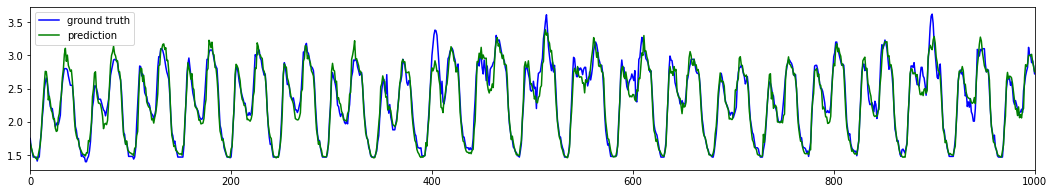

In [722]:
Y_test = demand_test['demand_MW']
X_test = pd.DataFrame.copy(weather_test)
#X_test['last_hour'] = demand_test['demand_MW'].shift(periods=2,  fill_value=1).values
X_test['last_day']  = demand_test['demand_MW'].shift(periods=48, fill_value=1).values
X_test['last_hour_mean'] = demand_test['4window'].shift(periods=2,  fill_value=1).values
X_test['last_day_mean']  = demand_test['48window'].shift(periods=48, fill_value=1).values
del X_test['train']

Y_test = Y_test.iloc[48:]
X_test = X_test.iloc[48:]

pred = xgb.predict(X_test) 
rmse = metrics.r2_score(Y_test, pred) 
print("RMSE : % f" %(rmse))

fig = mplt.figure(figsize=(18,3))
mplt.plot(Y_test.values,'b',label='ground truth');
mplt.plot(pred,'g',label='prediction');
mplt.xlim((0,1000));
mplt.legend();

In [596]:
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

<h1>predicting solar output based on weather</h1>

In [626]:
solar = pd.read_csv("D://competition/battery/pv_train_set0.csv")

In [627]:
solar['year']  = solar['datetime'].apply(lambda x:year_(x))
solar['month'] = solar['datetime'].apply(lambda x:month_(x))
solar['date']  = solar['datetime'].apply(lambda x:date_(x))
solar['day']   = solar['datetime'].apply(lambda x:day_(x))
solar['week']  = solar['date'].apply(lambda x:int(x/7))
solar['hour']  = solar['datetime'].apply(lambda x:hour_(x))
solar['time']  = solar['datetime'].apply(lambda x:time_(x))

In [628]:
solar['4window']  = solar['pv_power_mw'].rolling(4).mean()
solar['48window'] = solar['pv_power_mw'].rolling(48).mean()

In [629]:
solar_train  = solar[solar['train']=='train']
solar_test   = solar[solar['train']=='test']
solar_submit = solar[solar['train']=='submit']
solar_train.shape

(11088, 14)

In [648]:
weather_ = weather[weather['number']==1]
weather_ = weather_[['train','temp_location3', 'temp_location6',
       'temp_location2', 'temp_location4', 'temp_location5', 'temp_location1',
       'solar_location3', 'solar_location6', 'solar_location2',
       'solar_location4', 'solar_location5', 'solar_location1', 'month','week', 'day', 'time', 'hour', 'year']]
weather_train = weather_[weather_['train'] == 'train']
weather_test  = weather_[weather_['train'] == 'test']
weather_submit= weather_[weather_['train'] == 'submit']
weather_train.shape

(11088, 19)

In [649]:
Y_train = solar_train['pv_power_mw']
X_train = pd.DataFrame.copy(weather_train)

X_train['last_hour'] = solar_train['pv_power_mw'].shift(periods=2,  fill_value=1).values
X_train['last_day']  = solar_train['pv_power_mw'].shift(periods=48, fill_value=1).values
X_train['last_hour_mean'] = solar_train['4window'].shift(periods=2,  fill_value=1).values
X_train['last_day_mean']  = solar_train['48window'].shift(periods=48, fill_value=1).values
del X_train['train']

Y_train = Y_train.iloc[96:]
X_train = X_train.iloc[96:]
X_train.to_csv('train.csv')
Y_train.to_csv('ytrain.csv')
X_train.shape,Y_train.shape

The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


((10992, 22), (10992,))

In [699]:
xgb = xgboost.XGBRegressor(objective ='reg:squarederror', n_estimators = 60,colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 3, alpha = 30, seed = 123) 
xgb.fit(X_train, Y_train) 
pred1 = xgb.predict(X_train) 

rmse = metrics.r2_score(Y_train, pred1) 
print("RMSE : % f" %(rmse))

Series.base is deprecated and will be removed in a future version
Series.base is deprecated and will be removed in a future version


RMSE :  0.912185


RMSE :  0.917777


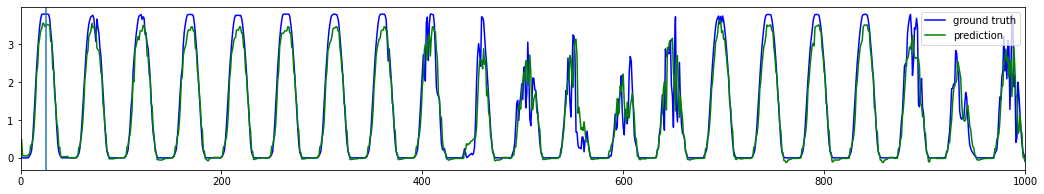

In [700]:
Y_test = solar_test['pv_power_mw']
X_test = pd.DataFrame.copy(weather_test)
X_test['last_hour'] = solar_test['pv_power_mw'].shift(periods=2,  fill_value=1).values
X_test['last_day']  = solar_test['pv_power_mw'].shift(periods=48, fill_value=1).values
X_test['last_hour_mean'] = solar_test['4window'].shift(periods=2,  fill_value=1).values
X_test['last_day_mean']  = solar_test['48window'].shift(periods=48, fill_value=1).values
del X_test['train']

pred2 = xgb.predict(X_test) 
rmse = metrics.r2_score(Y_test, pred2) 
print("RMSE : % f" %(rmse))

fig = mplt.figure(figsize=(18,3))
mplt.plot(Y_test.values,'b',label='ground truth');
mplt.plot(pred2,'g',label='prediction');
mplt.xlim((0,1000));
mplt.axvline(x=25);
mplt.legend();

In [701]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


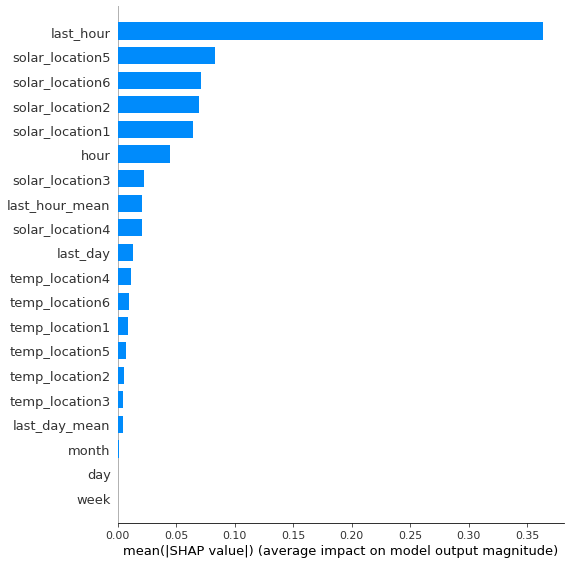

In [702]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [674]:
shap.force_plot(explainer.expected_value, shap_values[25,:], X_train.iloc[25,:])

<h1>Using all the Data to Predict Demand and solar</h1>

In [710]:
weather = weather[weather['number']==1]
weather = weather[['train','temp_location3', 'temp_location6',
       'temp_location2', 'temp_location4', 'temp_location5', 'temp_location1',
       'solar_location3', 'solar_location6', 'solar_location2',
       'solar_location4', 'solar_location5', 'solar_location1', 'month','week', 'day', 'time', 'hour', 'year']]
weather.shape,demand.shape,solar.shape

((12912, 19), (12912, 12), (12912, 14))

In [711]:
demand['4window']  = demand['demand_MW'].rolling(4).mean()
demand['48window'] = demand['demand_MW'].rolling(48).mean()
solar['4window']   = solar['pv_power_mw'].rolling(4).mean()
solar['48window']  = solar['pv_power_mw'].rolling(48).mean()

In [712]:
demand['last_hour'] = demand['demand_MW'].shift(periods=2,  fill_value=1).values
demand['last_day']  = demand['demand_MW'].shift(periods=48, fill_value=1).values
demand['last_hour_mean'] = demand['4window'].shift(periods=2,  fill_value=1).values
demand['last_day_mean']  = demand['48window'].shift(periods=48, fill_value=1).values

solar['last_hour'] = solar['pv_power_mw'].shift(periods=2,  fill_value=1).values
solar['last_day']  = solar['pv_power_mw'].shift(periods=48, fill_value=1).values
solar['last_hour_mean'] = solar['4window'].shift(periods=2,  fill_value=1).values
solar['last_day_mean']  = solar['48window'].shift(periods=48, fill_value=1).values

weather = weather.iloc[96:]
demand  = demand.iloc[96:]
solar   = solar.iloc[96:]

weather.shape,demand.shape,solar.shape

((12816, 19), (12816, 16), (12816, 18))

In [714]:
weather.to_csv('weather.csv',index=False)
demand.to_csv('demand.csv',index=False)
solar.to_csv('solar.csv',index=False)

In [717]:
X_demand = pd.DataFrame.copy(weather)
Y_demand = demand['demand_MW']
X_demand['last_hour'] = demand['last_hour']
X_demand['last_day']  = demand['last_day']
X_demand['last_hour_mean'] = demand['last_hour_mean']
X_demand['last_day_mean']  = demand['last_day_mean']

In [719]:
X_demand.head()

,train,temp_location3,temp_location6,temp_location2,temp_location4,temp_location5,temp_location1,solar_location3,solar_location6,solar_location2,...,month,week,day,time,hour,year,last_hour,last_day,last_hour_mean,last_day_mean
24936,train,7.03,10.83,8.01,6.15,10.98,7.98,0.0,0.0,0.0,...,11,0,6,0,0,2017,NaN,NaN,NaN,NaN
24936,train,7.03,10.83,8.01,6.15,10.98,7.98,0.0,0.0,0.0,...,11,0,6,0,0,2017,NaN,NaN,NaN,NaN
24937,train,6.59,10.77,7.72,5.77,10.97,7.88,0.0,0.0,0.0,...,11,0,6,0,1,2017,NaN,NaN,NaN,NaN
24937,train,6.59,10.77,7.72,5.77,10.97,7.88,0.0,0.0,0.0,...,11,0,6,0,1,2017,NaN,NaN,NaN,NaN
24938,train,6.14,10.67,7.38,5.43,10.93,7.59,0.0,0.0,0.0,...,11,0,6,0,2,2017,NaN,NaN,NaN,NaN


In [715]:
weather.columns

Index(['train', 'temp_location3', 'temp_location6', 'temp_location2',
       'temp_location4', 'temp_location5', 'temp_location1', 'solar_location3',
       'solar_location6', 'solar_location2', 'solar_location4',
       'solar_location5', 'solar_location1', 'month', 'week', 'day', 'time',
       'hour', 'year'],
      dtype='object')

In [ ]:
is_NaN = solar.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = solar[row_has_NaN]

print(rows_with_NaN)

In [454]:
import gurobipy
# installed in c/user/anaconda3
# license in c/user/ashutosh/gurobi

#  maximize
#        x +   y + 2 z
#  subject to
#        x + 2 y + 3 z <= 4
#        x +   y       >= 1
#        x, y, z binary

import gurobipy as gp
from gurobipy import GRB

try:

    # Create a new model
    m = gp.Model("mip1")

    # Create variables
    x = m.addVar(vtype=GRB.BINARY, name="x")
    y = m.addVar(vtype=GRB.BINARY, name="y")
    z = m.addVar(vtype=GRB.BINARY, name="z")

    # Set objective
    m.setObjective(x + y + 2 * z, GRB.MAXIMIZE)

    # Add constraint: x + 2 y + 3 z <= 4
    m.addConstr(x + 2 * y + 3 * z <= 4, "c0")

    # Add constraint: x + y >= 1
    m.addConstr(x + y >= 1, "c1")

    # Optimize model
    m.optimize()

    for v in m.getVars():
        print('%s %g' % (v.varName, v.x))

    print('Obj: %g' % m.objVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Academic license - for non-commercial use only - expires 2021-03-30
Using license file C:\Users\Ashutosh\gurobi.lic
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 2 rows, 3 columns and 5 nonzeros
Model fingerprint: 0xf43f5bdf
Variable types: 0 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 2 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 2: 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%
x 1
y 0
z 1
Obj: 3
